In [1]:
import numpy as np
import json
import pandas as pd
import os, glob, re, shutil
import PIL.ExifTags as ExifTags
import PIL.Image as Image
from PIL import ImageOps
import numpy as np
from tqdm import tqdm
from typing import Union
import cv2
from plyfile import PlyData, PlyElement 
from matplotlib import pyplot as plt
import subprocess
import logging

In [2]:
os.name

'posix'

In [3]:
if os.name == 'posix':  # Linux or macOS
    base_path = '/cs/student'
elif os.name == 'nt':  # Windows
    base_path = 'Y:/'
else:
    raise ValueError("Unsupported operating system")

In [4]:
import read_write_model

cams= read_write_model.read_cameras_binary("/cs/student/projects4/ml/2023/asrivast/datasets/dress3_15/upright/sparse/undistorted/sparse/cameras.bin")
# cams= read_write_model.read_cameras_binary("/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/0/cameras.bin")
print(cams)

for i, cam in cams.items():
    print(cam.id, cam.model, cam.width, cam.height, cam.params)
    
    

{9: Camera(id=9, model='PINHOLE', width=2865, height=4302, params=array([5142.0587862 , 5154.93615123, 1432.5       , 2151.        ])), 3: Camera(id=3, model='PINHOLE', width=3456, height=5196, params=array([12035.36486613, 12065.76959481,  1728.        ,  2598.        ])), 2: Camera(id=2, model='PINHOLE', width=4195, height=6341, params=array([6008.50388913, 6024.83616083, 2097.5       , 3170.5       ])), 1: Camera(id=1, model='PINHOLE', width=4191, height=6343, params=array([9095.28575261, 9121.51241943, 2095.5       , 3171.5       ]))}
9 PINHOLE 2865 4302 [5142.0587862  5154.93615123 1432.5        2151.        ]
3 PINHOLE 3456 5196 [12035.36486613 12065.76959481  1728.          2598.        ]
2 PINHOLE 4195 6341 [6008.50388913 6024.83616083 2097.5        3170.5       ]
1 PINHOLE 4191 6343 [9095.28575261 9121.51241943 2095.5        3171.5       ]


In [5]:

def qvec2rotmat(qvec, tvec):
    return np.array(
        [
            [
                1 - 2 * qvec[2] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
                2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2],
                tvec[0],
            ],
            [
                2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1],
                tvec[1],
            ],
            [
                2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
                2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[2] ** 2,
                tvec[2],
            ],
        ]
    )

In [6]:
imgs= read_write_model.read_images_binary("/cs/student/projects4/ml/2023/asrivast/datasets/dress3_15/upright/sparse/undistorted/sparse/images.bin")
print(imgs[1].qvec)
print(imgs[1].tvec)
print(imgs[1].name)

attrs = dir(imgs[1])
print(attrs)


[ 9.38762970e-01 -2.69317881e-03  3.44552760e-01  4.78572970e-04]
[-0.14354834 -0.84576733  2.10558252]
marie_PL-AB1_dress3+shoe_15.JPG
['__add__', '__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '_asdict', '_field_defaults', '_fields', '_fields_defaults', '_make', '_replace', 'camera_id', 'count', 'id', 'index', 'name', 'point3D_ids', 'qvec', 'qvec2rotmat', 'tvec', 'xys']


In [7]:
for i, search_txt in enumerate(["AB3", "AB6", "BB3", "BB7", "BB8", "DB9"]):
    # search_txt= "AB6"

    for _, img in imgs.items(): 
        # print(img.name)
        if search_txt in img.name:
            print(i)
            img_cam= cams[img.camera_id]
            # from PINHOLE params to intrinsic matrix
            fx= img_cam.params[0]
            fy= img_cam.params[1]
            cx= img_cam.params[2]
            cy= img_cam.params[3]
            K= np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
            
            # print each row of the intrinsic matrix without scientific notation
            np.set_printoptions(suppress=True)
            for row in K:
                for item in row:
                    print(item, end=' ')
                print()
            print("0 0")
            # from qvec and tvec to extrinsic matrix
            qvec= img.qvec
            tvec= img.tvec

            w2c= qvec2rotmat(qvec, tvec)
            for j, row in enumerate(w2c):
                if j==3:
                    break
                for item in row:
                    print(item, end=' ')
                print()
        # break

0
9095.285752610374 0.0 2095.5 
0.0 9121.512419427276 3171.5 
0.0 0.0 1.0 
0 0
0.7389654432201558 -0.006739489297584722 0.6737096206901357 -0.08459493853518774 
0.023765489939291687 0.9995884258755117 -0.016067991276517875 0.06393308016162998 
-0.673324049187599 0.027884729507825064 0.738821471429933 2.1322648917495552 
1
6008.503889129346 0.0 2097.5 
0.0 6024.836160830426 3170.5 
0.0 0.0 1.0 
0 0
0.7158659240448891 -0.031300567338437245 0.6975358437210586 -0.33478487396215684 
0.01275401890749048 0.9994142233386375 0.03175760050972354 -0.29348861346690513 
-0.6981212744166048 -0.013837798694870975 0.7158457945215686 2.1349281674549867 
2
9095.285752610374 0.0 2095.5 
0.0 9121.512419427276 3171.5 
0.0 0.0 1.0 
0 0
0.9998517012177732 0.01673968465913303 -0.004044567892576287 0.7552597028237511 
-0.016827132353619274 0.9996017839934984 -0.022652175475419846 -0.16403006109385246 
0.0036637670066002053 0.022716874664623632 0.9997352251555375 2.509840674317803 
3
9095.285752610374 0.0 2095.

# read .npz file

In [52]:
npz_file= "/cs/student/projects4/ml/2023/asrivast/datasets/SMPL/J_regressor_lsp.npz"
J_regressor= np.load(npz_file)
print(J_regressor.files)
print(J_regressor['joint_regressor'].shape)


['joint_regressor']
(14, 6890)


# Read .jpg and corresponding OpenPose .json file

In [3]:
%matplotlib ipympl

total keypoints:  17


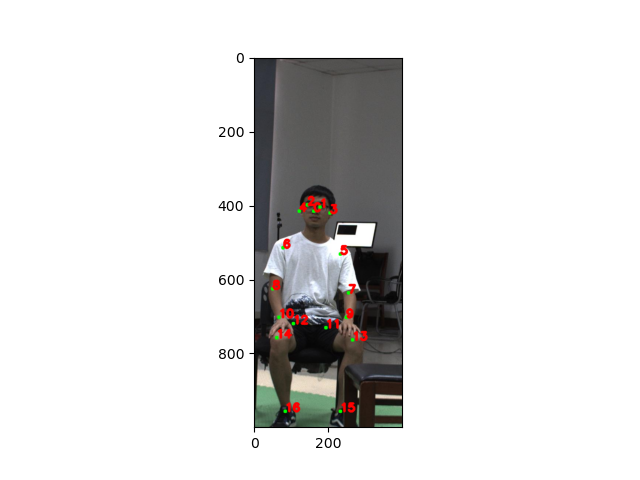

True


In [12]:
img= "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data/images/0000/Camera05/00001.jpg"
open_pose_json = "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data/keypoints/0000/Camera05/00001_keypoints.json"

plt.close()
with open(open_pose_json) as f:
    data = json.load(f)
    keypoints= data['people'][0]['pose_keypoints_2d']
    
    # keypoints are in the format x1, y1, c1, x2, y2, c2, ..., xN, yN, cN
    x, y, c = keypoints[0::3], keypoints[1::3], keypoints[2::3]

    # open image
    img= Image.open(img)
    total_keypoints= len(x)
    print("total keypoints: ", total_keypoints)
    # overlay image and keypoints 
    img= np.array(img)
    for i in range(len(x)):
        if c[i]>0.1 or True:
            cv2.circle(img, (int(x[i]), int(y[i])), 5, (0, 255, 0), -1)
            cv2.putText(img, str(i), (int(x[i]), int(y[i])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 6)
    
    # just show this new image here
    plt.imshow(img[200:1200, 800:1200,:])
    plt.show()
    print(plt.isinteractive())

In [162]:
%matplotlib ipympl
# %matplotlib

total keypoints:  18


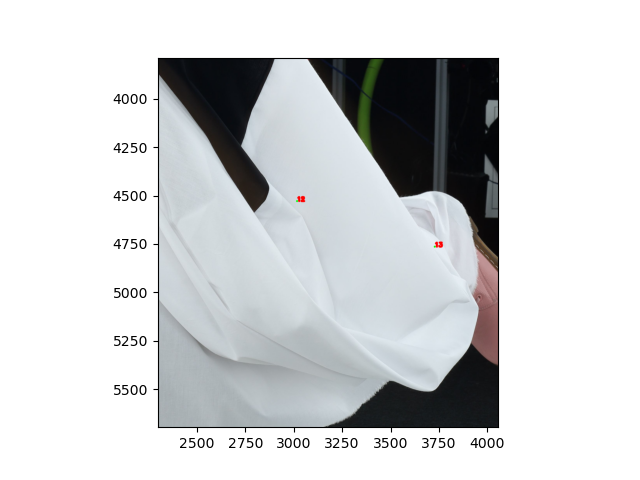

In [14]:
img= "/cs/student/projects4/ml/2023/asrivast/datasets/SMPL/large/images/0000/cam001/marie_PL-AB3_dress3+shoe_15.JPG"
open_pose_json = "/cs/student/projects4/ml/2023/asrivast/datasets/SMPL/large/keypoints/0000/cam001/marie_PL-AB3_dress3+shoe_15_keypoints.json"

with open(open_pose_json) as f:
    data = json.load(f)
    keypoints= data['people'][0]['pose_keypoints_2d']
    
    # keypoints are in the format x1, y1, c1, x2, y2, c2, ..., xN, yN, cN
    x, y, c = keypoints[0::3], keypoints[1::3], keypoints[2::3]

    # open image
    img= Image.open(img)
    total_keypoints= len(x)
    print("total keypoints: ", total_keypoints)

    # overlay image and keypoints 
    img= np.array(img)
    for i in range(len(x)):
        if c[i]>0.1 or True:
            cv2.circle(img, (int(x[i]), int(y[i])), 5, (0, 255, 0), -1)
            cv2.putText(img, str(i), (int(x[i]), int(y[i])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 10)
    
    # just show this new image here 
    plt.imshow(img)
    plt.show()

# Read keypoints.json files for all images

In [119]:
def check_all_keypoints(person_dict: dict, allow_missing:int= 0)->bool:
    """
    checks whterher all keypoints are present in the person_dict
    person_dict is a single dict
    """
    keypoints= person_dict['pose_keypoints_2d']
    x, y, c = keypoints[0::3], keypoints[1::3], keypoints[2::3]
    # count zeros in either x or y or c
    total_zeros= sum([1 for i in range(len(x)) if x[i]==0 or y[i]==0 or c[i]==0])
    total_keypoints= len(x)- total_zeros
    if total_keypoints+ allow_missing< len(x):
        return False
    return True


In [120]:
all_keypoints_json= glob.glob("/cs/student/projects4/ml/2023/asrivast/datasets/dress3_15/upright/OpenPose_keypoints/*.json")


for i, keypoint_json in enumerate(all_keypoints_json):
    with open(keypoint_json) as f:
        data = json.load(f)

        for people in data["people"]:
            if check_all_keypoints(people, 1) is True:
                print(i, os.path.basename(keypoint_json), )
                
        
        # keypoints= data['people'][0]['pose_keypoints_2d']

        # # keypoints are in the format x1, y1, c1, x2, y2, c2, ..., xN, yN, cN
        # x, y, c = keypoints[0::3], keypoints[1::3], keypoints[2::3]

        # # open image
        # img= Image.open(keypoint_json.replace("OpenPose_keypoints", "images").replace("json", "jpg"))
        # total_keypoints= len(x)
        # print("total keypoints: ", total_keypoints)

        # # overlay image and keypoints 
        # img= np.array(img)
        # for i in range(len(x)):
        #     if c[i]>0.1 or True:
        #         cv2.circle(img, (int(x[i]), int(y[i])), 5, (0, 255, 0), -1)
        #         cv2.putText(img, str(i), (int(x[i]), int(y[i])), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 6)

        

18 marie_PL-BB8_dress3+shoe_15_keypoints.json
19 marie_PL-BB7_dress3+shoe_15_keypoints.json
22 marie_PL-BB3_dress3+shoe_15_keypoints.json
27 marie_PL-AB6_dress3+shoe_15_keypoints.json
30 marie_PL-AB3_dress3+shoe_15_keypoints.json
87 marie_PL-JB2_dress3+shoe_15_keypoints.json
96 marie_PL-KB7_dress3+shoe_15_keypoints.json


In [ ]:
# make folder structure compatible with MvSMPL

# SMPL
# |---images
#     |---0000
#         |----cam001
#         |----cam002
#         ....
# |---keypoints
#     |---0000
#         |----cam0001
#         |----cam0002
#         ....

In [134]:
all_jpgs= glob.glob("/cs/student/projects4/ml/2023/asrivast/datasets/SMPL/large/images/*.JPG")
all_jpgs= sorted(all_jpgs)
print(len(all_jpgs))

os.makedirs("/cs/student/projects4/ml/2023/asrivast/datasets/SMPL/large/images/0000", exist_ok= True)
# iterate over all jpgs and move them to the folders named cam01, cam02, etc
for i, jpg in enumerate(all_jpgs):
    cam= "cam"+ str(i+1).zfill(3)
    os.makedirs(os.path.join("/cs/student/projects4/ml/2023/asrivast/datasets/SMPL/large/images/0000", cam), exist_ok= True)
    shutil.move(jpg, os.path.join("/cs/student/projects4/ml/2023/asrivast/datasets/SMPL/large/images/0000", cam))
    

7


In [137]:
# now with jsons
all_jsons= glob.glob("/cs/student/projects4/ml/2023/asrivast/datasets/SMPL/large/keypoints/*.json")
all_jsons= sorted(all_jsons)
print(len(all_jsons))

os.makedirs("/cs/student/projects4/ml/2023/asrivast/datasets/SMPL/large/keypoints/0000", exist_ok= True)
# iterate over all jpgs and move them to the folders named cam01, cam02, etc
for i, jpg in enumerate(all_jsons):
    cam= "cam"+ str(i+1).zfill(3)
    os.makedirs(os.path.join("/cs/student/projects4/ml/2023/asrivast/datasets/SMPL/large/keypoints/0000", cam), exist_ok= True)
    shutil.move(jpg, os.path.join("/cs/student/projects4/ml/2023/asrivast/datasets/SMPL/large/keypoints/0000", cam))

7


# Part II

How do we make the camera_params in the first place

# read .txt file from data given in repo and make COLMAP .txt file

https://colmap.github.io/faq.html#reconstruct-sparse-dense-model-from-known-camera-poses

In [121]:
def load_camera_para(file):
    """"
    load camera parameters
    """
    campose = []
    intra = []
    campose_ = []
    intra_ = []
    f = open(file, 'r')
    for line in f:
        line = line.strip('\n')
        line = line.rstrip()
        words = line.split()
        if len(words) == 3:
            intra_.append([float(words[0]), float(words[1]), float(words[2])])
        elif len(words) == 4:
            campose_.append([float(words[0]), float(words[1]),
                            float(words[2]), float(words[3])])
        else:
            pass

    index = 0
    intra_t = []
    for i in intra_:
        index += 1
        intra_t.append(i)
        if index == 3:
            index = 0
            intra.append(intra_t)
            intra_t = []

    index = 0
    campose_t = []
    for i in campose_:
        index += 1
        campose_t.append(i)
        if index == 3:
            index = 0
            campose_t.append([0., 0., 0., 1.])
            campose.append(campose_t)
            campose_t = []

    return np.array(campose), np.array(intra)

In [122]:

try:
    campose, intrinsics= load_camera_para("Y:/MvSMPLfitting/data/3DOH50K_Parameters.txt")
except FileNotFoundError:
    campose, intrinsics= load_camera_para("/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data/3DOH50K_Parameters.txt")
# campose N, 4, 4
# intrinsics N, 3, 3

# print intrinsics in COLMAP .txt format. increase camera model by 1 to match COLMAP
# CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]
print(f'''# Camera list with one line of data per camera:
#   CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]
# Number of cameras: {intrinsics.shape[0]}''')
for i, intr in enumerate(intrinsics):
    w, h= 2048 ,1536
    fx, fy, cx, cy= intr[0,0], intr[1,1], intr[0,2], intr[1,2]
    print(i+1, "PINHOLE", w, h, fx, fy, cx, cy) 


print("\n\n\n\n")
for i, intr in enumerate(intrinsics):
    w, h= 2048 ,1536
    fx, fy, cx, cy= intr[0,0], intr[1,1], intr[0,2], intr[1,2]
    print(i+1, "PINHOLE", f"{w}, {h}, {fx}, {fy}, {cx}, {cy}") 

# Camera list with one line of data per camera:
#   CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]
# Number of cameras: 6
1 PINHOLE 2048 1536 2398.95250917519 2398.95250917519 1022.838 767.0612
2 PINHOLE 2048 1536 2418.46884683428 2418.46884683428 1036.4757 762.90744
3 PINHOLE 2048 1536 2404.8628440717 2404.8628440717 1022.42111 774.58679
4 PINHOLE 2048 1536 2418.98884925097 2418.98884925097 1023.98034 774.29853
5 PINHOLE 2048 1536 2418.36776172459 2418.36776172459 1034.79508 766.41563
6 PINHOLE 2048 1536 2390.21408950408 2390.21408950408 1024.318747 772.82566





1 PINHOLE 2048, 1536, 2398.95250917519, 2398.95250917519, 1022.838, 767.0612
2 PINHOLE 2048, 1536, 2418.46884683428, 2418.46884683428, 1036.4757, 762.90744
3 PINHOLE 2048, 1536, 2404.8628440717, 2404.8628440717, 1022.42111, 774.58679
4 PINHOLE 2048, 1536, 2418.98884925097, 2418.98884925097, 1023.98034, 774.29853
5 PINHOLE 2048, 1536, 2418.36776172459, 2418.36776172459, 1034.79508, 766.41563
6 PINHOLE 2048, 1536, 2390.21408950408,

In [83]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def get_quaternion_translation(matrix):
    """
    Extracts the quaternion and translational vector from a 4x4 matrix.

    Args:
    - matrix: A 4x4 NumPy array representing the transformation matrix.

    Returns:
    - A tuple containing the quaternion and translational vector.
    """
    # Extract the rotation matrix from the upper-left 3x3 part of the matrix
    rotation_matrix = matrix[:3, :3]

    # Convert the rotation matrix to a quaternion
    quaternion = R.from_matrix(rotation_matrix).as_quat()

    # Extract the translational vector from the upper-right 3x1 part of the matrix
    translation = matrix[:3, 3]

    return quaternion, translation

def rotmat2qvec(R):
    Rxx, Ryx, Rzx, Rxy, Ryy, Rzy, Rxz, Ryz, Rzz = R.flat
    K = (
        np.array(
            [
                [Rxx - Ryy - Rzz, 0, 0, 0],
                [Ryx + Rxy, Ryy - Rxx - Rzz, 0, 0],
                [Rzx + Rxz, Rzy + Ryz, Rzz - Rxx - Ryy, 0],
                [Ryz - Rzy, Rzx - Rxz, Rxy - Ryx, Rxx + Ryy + Rzz],
            ]
        )
        / 3.0
    )
    eigvals, eigvecs = np.linalg.eigh(K)
    qvec = eigvecs[[3, 0, 1, 2], np.argmax(eigvals)]
    if qvec[0] < 0:
        qvec *= -1
    return qvec

def compare_quaternions(q1, q2, tolerance=1e-6):
    """
    Compares two quaternions to see if they are approximately equal.

    Args:
    - q1: First quaternion as a NumPy array.
    - q2: Second quaternion as a NumPy array.
    - tolerance: The tolerance for the comparison.

    Returns:
    - True if the quaternions are approximately equal, False otherwise.
    """
    return np.allclose(q1, q2, atol=tolerance) or np.allclose(q1, -q2, atol=tolerance)

def qvec2rotmat(qvec):
    return np.array(
        [
            [
                1 - 2 * qvec[2] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
                2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2],
            ],
            [
                2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1],
            ],
            [
                2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
                2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[2] ** 2,
            ],
        ]
    )


# compare with campose[0]
# q, t= get_quaternion_translation(campose[0])
# print("quaternion: ", q)

q2= rotmat2qvec(campose[0][:3, :3])
print("quaternion2: ", q2)

print("compare quaternions: ", compare_quaternions(q, q2))

quaternion2:  [ 0.0089795   0.76368985 -0.18481198  0.61849957]
compare quaternions:  False


In [75]:
# print campose in COLMAP .txt format. this will be the images.txt file
# IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME

print(f'''# Image list with two lines of data per image:
#   IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
#   POINTS2D[] as (X, Y, POINT3D_ID)
# Number of images: {campose.shape[0]}, mean observations per image: 0''')

for i, camp in enumerate(campose):
    # q, t= get_quaternion_translation(camp)
    q= rotmat2qvec(camp[:3, :3])
    t= camp[:3, 3]
    print(i+1, q[0], q[1], q[2], q[3], t[0], t[1], t[2], i+1, f"0000/Camera0{i}/00001.jpg")
    print()

# Image list with two lines of data per image:
#   IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME
#   POINTS2D[] as (X, Y, POINT3D_ID)
# Number of images: 6, mean observations per image: 0
1 0.0089794968444876 0.7636898511313638 -0.18481197922067394 0.618499565280294 11.909454043496599 -5.446204352747883 26.467684858689605 1 0000/Camera00/00001.jpg

2 0.06336158705598766 0.7443880074907859 0.07138468703681 -0.6608903313306231 -13.699860315783948 -2.474198516323067 25.431383471774243 2 0000/Camera01/00001.jpg

3 0.04770639743537517 0.9565649111983059 0.011631021677351083 -0.28735411888931783 -8.614951133534133 -1.77651919492546 19.380850499269233 3 0000/Camera02/00001.jpg

4 0.04470154794184573 0.9589942283160435 -0.04535677326959092 0.27617857409055085 6.498464239351408 -3.3095316017484615 21.50535934865188 4 0000/Camera03/00001.jpg

5 0.028258462615619286 0.3796014058675178 0.1117682921262636 -0.9179390398219176 -9.70675844846761 -3.9977853072052567 40.02720817109032 5 0000/Cam

In [85]:
q_vec= np.array([0.06336158705598766, 0.7443880074907859, 0.07138468703681, -0.6608903313306231])
rot_mat= qvec2rotmat(q_vec)
for row in rot_mat:
    for item in row:
        print(item, end=' ')
    print()

0.11625639282071176 0.19002593042350027 -0.9748715796939612 
0.022525689371237057 -0.9817790714848065 -0.18868611001550167 
-0.9929637679425504 -2.3687855259149626e-05 -0.11841855847889143 


In [40]:
def pair_id_to_image_ids(pair_id):
    image_id2 = pair_id % 2147483647
    image_id1 = (pair_id - image_id2) / 2147483647
    return image_id1, image_id2

In [41]:
import subprocess
import os, logging


In [87]:
# remove all Thumbs.db file in this and all subdirectories /cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/images
# for root, dirs, files in os.walk("/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/images"):
for root, dirs, files in os.walk("/cs/student/projects4/ml/2023/asrivast/datasets/SMPL/results8"):
    
    for file in files:
        if file == "Thumbs.db":
            os.remove(os.path.join(root, file))

PermissionError: [Errno 13] Permission denied: '/cs/student/projects4/ml/2023/asrivast/datasets/SMPL/results8/images/0000/marie_PL-BB7_dress3+shoe_15/Thumbs.db'

In [56]:
# remove the database file if it exists
command= "rm -rf /cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/database.db"
exit_code = os.system(command)
if exit_code != 0:
    logging.error(f"Failed to remove database file with code {exit_code}. Exiting.")
    exit(exit_code)

# run this command using subprocess
#  colmap feature_extractor \
    # --database_path $PROJECT_PATH/database.db \
    # --image_path $PROJECT_PATH/images

command = ["colmap", "feature_extractor",
           "--ImageReader.camera_model", "PINHOLE",
           "--database_path", "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/database.db",
           "--image_path", "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/images",
           "--SiftExtraction.max_num_features", "20000"]

command = " ".join(command)
exit_code = os.system(command)
if exit_code != 0:
    logging.error(f"Feature extractor failed with code {exit_code}. Exiting.")
    exit(exit_code)


I20240803 00:30:00.467494 139770880466944 misc.cc:198] 
Feature extraction
I20240803 00:30:00.469195 139770147614720 sift.cc:716] Creating SIFT GPU feature extractor
I20240803 00:30:00.871951 139770139222016 feature_extraction.cc:257] Processed file [1/6]
I20240803 00:30:00.871978 139770139222016 feature_extraction.cc:260]   Name:            0000/Camera00/00001.jpg
I20240803 00:30:00.871982 139770139222016 feature_extraction.cc:286]   Dimensions:      2048 x 1536
I20240803 00:30:00.871985 139770139222016 feature_extraction.cc:289]   Camera:          #1 - PINHOLE
I20240803 00:30:00.871989 139770139222016 feature_extraction.cc:292]   Focal Length:    2457.60px
I20240803 00:30:00.871998 139770139222016 feature_extraction.cc:296]   Features:        2826
I20240803 00:30:01.145530 139770139222016 feature_extraction.cc:257] Processed file [2/6]
I20240803 00:30:01.145549 139770139222016 feature_extraction.cc:260]   Name:            0000/Camera01/00001.jpg
I20240803 00:30:01.145552 139770139222

In [9]:
import importlib
try:
    importlib.reload(database)
except NameError:
    from  database import *
    import database


In [57]:


db = database.COLMAPDatabase.connect("/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/database.db")

rows = db.execute("SELECT * FROM cameras")
for camera_id, model, width, height, params, prior in rows:
    params = blob_to_array(params, np.float64)
    print(f"camera_id: {camera_id}, model: {model}, width: {width}, height: {height}", params)

db.close()

camera_id: 1, model: 1, width: 2048, height: 1536 [2457.6 2457.6 1024.   768. ]
camera_id: 2, model: 1, width: 2048, height: 1536 [2457.6 2457.6 1024.   768. ]
camera_id: 3, model: 1, width: 2048, height: 1536 [2457.6 2457.6 1024.   768. ]
camera_id: 4, model: 1, width: 2048, height: 1536 [2457.6 2457.6 1024.   768. ]
camera_id: 5, model: 1, width: 2048, height: 1536 [2457.6 2457.6 1024.   768. ]
camera_id: 6, model: 1, width: 2048, height: 1536 [2457.6 2457.6 1024.   768. ]


In [61]:


db = database.COLMAPDatabase.connect("/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/database.db")

rows = db.execute("SELECT * FROM cameras")

for camera_id, model, width, height, params, prior in rows:
    width, height = int(width), int(height)
    # print(f"camera_id: {camera_id}, model: {model}, width: {width}, height: {height}")
    params = blob_to_array(params, np.float64)
    
    # Modify the value here
    fx, fy, cx, cy = intrinsics[camera_id-1][0,0], intrinsics[camera_id-1][1,1], intrinsics[camera_id-1][0,2], intrinsics[camera_id-1][1,2]
    params[0], params[1], params[2], params[3]= fx, fy, cx, cy
    # print(params)
    
    # # Update the value in the database
    db.execute("UPDATE cameras SET params = ? WHERE camera_id = ?", (array_to_blob(params), camera_id))

db.commit()
db.close()


In [62]:

db = database.COLMAPDatabase.connect("/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/database.db")

rows = db.execute("SELECT * FROM cameras")
for camera_id, model, width, height, params, prior in rows:
    params = blob_to_array(params, np.float64)
    print(f"camera_id: {camera_id}, model: {model}, width: {width}, height: {height}", params)


db.close()



camera_id: 1, model: 1, width: 2048, height: 1536 [2398.95250918 2398.95250918 1022.838       767.0612    ]
camera_id: 2, model: 1, width: 2048, height: 1536 [2418.46884683 2418.46884683 1036.4757      762.90744   ]
camera_id: 3, model: 1, width: 2048, height: 1536 [2404.86284407 2404.86284407 1022.42111     774.58679   ]
camera_id: 4, model: 1, width: 2048, height: 1536 [2418.98884925 2418.98884925 1023.98034     774.29853   ]
camera_id: 5, model: 1, width: 2048, height: 1536 [2418.36776172 2418.36776172 1034.79508     766.41563   ]
camera_id: 6, model: 1, width: 2048, height: 1536 [2390.2140895 2390.2140895 1024.318747   772.82566  ]


In [63]:
db = database.COLMAPDatabase.connect("/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/database.db")

rows = db.execute("SELECT * FROM images")
# for image_id, image_name, camera_id, _1, _2, _3 in rows:
for row in rows:
    print(row)
    image_id, image_name, camera_id= row[0], row[1], row[2]
    # print(f"image_id: {image_id}, camera_id: {camera_id}, name: {image_name}")

db.close()

(1, '0000/Camera00/00001.jpg', 1)
(2, '0000/Camera01/00001.jpg', 2)
(3, '0000/Camera02/00001.jpg', 3)
(4, '0000/Camera03/00001.jpg', 4)
(5, '0000/Camera04/00001.jpg', 5)
(6, '0000/Camera05/00001.jpg', 6)


In [64]:
db = database.COLMAPDatabase.connect("/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/database.db")

rows = db.execute("SELECT * FROM keypoints")
# for image_id, image_name, camera_id, _1, _2, _3 in rows:
for row in rows:
    img, total_keypoints= row[0], row[1]
    print(img, total_keypoints)
    
    # print(f"image_id: {image_id}, camera_id: {camera_id}, name: {image_name}")

db.close()

1 2826
2 4727
3 16849
4 19767
5 14630
6 4836


In [65]:
command = ["colmap", "exhaustive_matcher",
           "--database_path", "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/database.db",
           "--log_level", "2"]

command = " ".join(command)
exit_code = os.system(command)
if exit_code != 0:
    logging.error(f"Exhaustive matcher failed with code {exit_code}. Exiting.")
    exit(exit_code)


I20240803 00:31:38.220268 140237893148672 misc.cc:198] 
Feature matching
I20240803 00:31:38.239319 140237884755968 sift.cc:1451] Creating SIFT GPU feature matcher
I20240803 00:31:38.325803 140237893148672 pairing.cc:168] Generating exhaustive image pairs...
I20240803 00:31:38.325817 140237893148672 pairing.cc:202] Matching block [1/1, 1/1]
I20240803 00:31:38.623770 140237893148672 feature_matching.cc:46]  in 0.298s
I20240803 00:31:38.624834 140237893148672 timer.cc:91] Elapsed time: 0.007 [minutes]


In [66]:
db = database.COLMAPDatabase.connect("/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/database.db")


rows = db.execute("SELECT * FROM matches")
# for image_id, image_name, camera_id, _1, _2, _3 in rows:
for row in rows:
    pair_id, num_matches= row[0], row[1]
    image_id1, image_id2= pair_id_to_image_ids(pair_id) 
    print(int(image_id1),"<---->", image_id2, num_matches)
    # print(f"image_id: {image_id}, camera_id: {camera_id}, name: {image_name}")

db.close()

1 <----> 2 20
1 <----> 3 25
1 <----> 4 50
1 <----> 5 41
1 <----> 6 48
2 <----> 3 109
2 <----> 4 45
2 <----> 5 95
2 <----> 6 31
3 <----> 4 77
3 <----> 5 50
3 <----> 6 51
4 <----> 5 50
4 <----> 6 33
5 <----> 6 30


In [76]:



command = [
    "colmap", "point_triangulator",
    "--database_path", "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/database.db",
    "--image_path", "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/images",
    "--input_path", "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/0",
    "--output_path", "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/tri_0",
    "--log_level", "2",
    "--Mapper.min_num_matches", "5"
]
command= " ".join(command)

exit_code = os.system(command)
if exit_code != 0:
    logging.error(f"Point triangulation failed with code {exit_code}. Exiting.")
    exit(exit_code)

I20240803 00:35:49.037875 140329645223936 misc.cc:198] 
Loading model
I20240803 00:35:49.150582 140329645223936 incremental_mapper.cc:225] Loading database
I20240803 00:35:49.188352 140329645223936 database_cache.cc:65] Loading cameras...
I20240803 00:35:49.191542 140329645223936 database_cache.cc:75]  6 in 0.003s
I20240803 00:35:49.191551 140329645223936 database_cache.cc:83] Loading matches...
I20240803 00:35:49.198787 140329645223936 database_cache.cc:89]  8 in 0.007s
I20240803 00:35:49.198794 140329645223936 database_cache.cc:105] Loading images...
I20240803 00:35:49.435654 140329645223936 database_cache.cc:155]  6 in 0.237s (connected 6)
I20240803 00:35:49.435669 140329645223936 database_cache.cc:166] Building correspondence graph...
I20240803 00:35:49.436057 140329645223936 database_cache.cc:195]  in 0.000s (ignored 0)
I20240803 00:35:49.436062 140329645223936 timer.cc:91] Elapsed time: 0.004 [minutes]
I20240803 00:35:49.442404 140329645223936 incremental_mapper.cc:546] Iterative

In [82]:
# colmap model_converter \
#    --input_path $PROJECT_PATH/sparse/ \
#    --output_path $PROJECT_PATH/inputs/ \
#    --output_type TXT

command = [
    "colmap", "model_converter",
    "--input_path", "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/dense_tri_0/sparse",
    "--output_path", "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/dense_tri_0/sparse",
    "--output_type", "TXT"
]

command= " ".join(command)

exit_code = os.system(command)
if exit_code != 0:
    logging.error(f"Point triangulation failed with code {exit_code}. Exiting.")
    exit(exit_code)

In [79]:
# colmap image_undistorter \
#     --image_path $PROJECT_PATH/images \
#     --input_path path/to/triangulated/sparse/model \
#     --output_path path/to/dense/workspace

command = [
    "colmap", "image_undistorter",
    "--image_path", "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/images",
    "--input_path", "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/tri_0",
    "--output_path", "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/dense_tri_0",
    "--output_type", "COLMAP"
]

command= " ".join(command)

exit_code = os.system(command)
if exit_code != 0:
    logging.error(f"Image undistortion failed with code {exit_code}. Exiting.")
    exit(exit_code)

I20240803 00:40:11.507371 140102765666304 misc.cc:198] 
Reading reconstruction
I20240803 00:40:11.511515 140102765666304 image.cc:348] => Reconstruction with 6 images and 1 points
I20240803 00:40:11.511532 140102765666304 misc.cc:198] 
Image undistortion
I20240803 00:40:11.530009 140102765666304 undistortion.cc:214] Undistorting image [1/6]
I20240803 00:40:11.535288 140099449630720 undistortion.cc:259] Undistorted image found; copying to location: /cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/dense_tri_0/images/0000/Camera00/00001.jpg
I20240803 00:40:11.548303 140099382489088 undistortion.cc:259] Undistorted image found; copying to location: /cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/dense_tri_0/images/0000/Camera01/00001.jpg
I20240803 00:40:11.548307 140099432845312 undistortion.cc:259] Undistorted image found; copying to location: /cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/dense_tri_0/images/0000/Came

In [80]:

# colmap patch_match_stereo \
#     --workspace_path path/to/dense/workspace

command = [
    "colmap", "patch_match_stereo",
    "--workspace_path", "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/dense_tri_0"
]

command= " ".join(command)

exit_code = os.system(command)
if exit_code != 0:
    logging.error(f"Patch match stereo failed with code {exit_code}. Exiting.")
    exit(exit_code)

I20240803 00:42:42.519410 140403220258816 patch_match.cc:233] Reading workspace...
I20240803 00:42:42.560152 140403220258816 patch_match.cc:263] Reading configuration...
W20240803 00:42:42.560663 140403220258816 patch_match.cc:385] Ignoring reference image 0000/Camera01/00001.jpg, because it has no source images.
W20240803 00:42:42.560669 140403220258816 patch_match.cc:385] Ignoring reference image 0000/Camera02/00001.jpg, because it has no source images.
W20240803 00:42:42.560671 140403220258816 patch_match.cc:385] Ignoring reference image 0000/Camera04/00001.jpg, because it has no source images.
W20240803 00:42:42.560672 140403220258816 patch_match.cc:385] Ignoring reference image 0000/Camera05/00001.jpg, because it has no source images.
I20240803 00:42:42.560674 140403220258816 patch_match.cc:394] Configuration has 2 problems...
I20240803 00:42:42.601334 140399882022912 misc.cc:198] 
Processing view 1 / 2 for 0000/Camera00/00001.jpg
I20240803 00:42:42.601391 140399882022912 patch_ma

In [81]:

# colmap stereo_fusion \
#     --workspace_path path/to/dense/workspace \
#     --output_path path/to/dense/workspace/fused.ply

command = [
    "colmap", "stereo_fusion",
    "--workspace_path", "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/dense_tri_0",
    "--output_path", "/cs/student/projects4/ml/2023/asrivast/MvSMPLfitting/data_COLMAP/sparse/dense_tri_0/fused.ply"
]

command= " ".join(command)

exit_code = os.system(command)
if exit_code != 0:
    logging.error(f"Stereo fusion failed with code {exit_code}. Exiting.")
    exit(exit_code)

I20240803 00:46:01.659488 140121243729920 misc.cc:205] 
StereoFusion::Options
---------------------
I20240803 00:46:01.659522 140121243729920 fusion.cc:89] mask_path: 
I20240803 00:46:01.659524 140121243729920 fusion.cc:90] max_image_size: -1
I20240803 00:46:01.659526 140121243729920 fusion.cc:91] min_num_pixels: 5
I20240803 00:46:01.659527 140121243729920 fusion.cc:92] max_num_pixels: 10000
I20240803 00:46:01.659529 140121243729920 fusion.cc:93] max_traversal_depth: 100
I20240803 00:46:01.659530 140121243729920 fusion.cc:94] max_reproj_error: 2
I20240803 00:46:01.659534 140121243729920 fusion.cc:95] max_depth_error: 0.01
I20240803 00:46:01.659536 140121243729920 fusion.cc:96] max_normal_error: 10
I20240803 00:46:01.659538 140121243729920 fusion.cc:97] check_num_images: 50
I20240803 00:46:01.659539 140121243729920 fusion.cc:98] use_cache: 0
I20240803 00:46:01.659541 140121243729920 fusion.cc:99] cache_size: 32
I20240803 00:46:01.659543 140121243729920 fusion.cc:102] bbox_min: -3.40282e

In [9]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'